In [1]:
# ridge svd?
#wanna go QR _or_ cholesky or what its called? check monday
#expand a bit to allow looping over noise weights?
#first mse r2 for low N?
#Most kFold versions look similar. introduce a "method" parameter and consolidate
#bias also increases with model complexity?

#validation set too?
#CENTER DATA?
#program likes cubic input, fix
# Ridge, 0 lambda best?
#VARIANCES SAME?!?!?!!?

#split in 3, train test to find poly degree, then use thiese betas with validation set to adjust hyperparameters?

In [2]:
#import packages
import numpy as np
import csv
from imageio import imread
from random import random, seed
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
import scipy.linalg as scl
from sklearn.model_selection import KFold
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# Function definitions

In [3]:
"""
This is an "uglified" version of the FrankeFunction, to minimize use of costly functions like divisions and powers.
It takes as input parameters a meshgrid of coordinates in the x and y direction.
"""
def FrankeFunction(x,y): #still got one division in here
    term1 = 0.75*np.exp(-(0.25*(9*x-2)*(9*x-2)) - 0.25*((9*y-2)*(9*y-2)))
    term2 = 0.75*np.exp(-((9*x+1)*(9*x+1))/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)*(9*x-7)*0.25 - 0.25*((9*y-3)*(9*y-3)))
    term4 = -0.2*np.exp(-(9*x-4)*(9*x-4) - (9*y-7)*(9*y-7))
    return term1 + term2 + term3 + term4

In [4]:
"""
This function creates the Model Matrix, usually dubbed X, for regression analysis.
It takes as input parameters a meshgrid of coordinates in the x and y direction, 
and the polynomial degree P that you wish to fit.

The order of columns is different from the one scikit learn creates, so take care to use the same model-creator when
comparing scikit and this code.

The ordering this function creates is: x^0y^0, x^1y^0, x^2y^0, x^0y^1, x^1y^1, x^0y^2 for a 2nd order polynomial.
"""
def Model(x,y,P): 
    m = len(x)*len(y) # number of equations
    t = sum(range(P+2)) # number of terms in polynomial
    X = np.zeros((m,t)) # Model matrix
    a = np.matrix.flatten(x)
    b = np.matrix.flatten(y)
    c = 0 #counter
    for i in range(P+1):
        for j in range(P+1-i):
            X[:,c] = a**j*b**i
            c +=1
    return X

In [5]:
def ols_svd(X: np.ndarray, z: np.ndarray) -> np.ndarray:
    u, s, v = scl.svd(X)
    return v.T @ scl.pinv(scl.diagsvd(s, u.shape[0], v.shape[0])) @ u.T @ z

In [6]:
def Ridge_betas(X,z_n,_lambda):
    return np.linalg.inv(X.T.dot(X)+_lambda*np.eye(len(X[0][:]))).dot(X.T).dot(z_n)

In [7]:
"""
Just a standard R2 score calculator, taking the measured/real data as the first input, and the values the 
regression model finds as the second input
"""
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

In [8]:
"""
Standard mean squared error calculator, inputs are measured/real data and regression model values.
"""
def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

In [9]:
def VarOLS_betas(X, sigma):
    covar = np.linalg.inv(X.T.dot(X))
    vari = np.diagonal(covar)
    return vari*(sigma**2)

In [10]:
def VarRidge_betas(X,_lambda,sigma):
    XX = X.T@X
    invers = np.linalg.inv(XX+_lambda*np.eye(len(XX)))
    return np.diagonal(invers)*(sigma**2)

In [11]:
def NoResampling(X,z_n,_lambda,method='ols'):
    if method =='ols':
        beta = np.linalg.inv(X.T.dot(X)+_lambda*np.eye(len(X[0][:]))).dot(X.T).dot(z_n)
    elif method == 'svd':
        beta = ols_svd(X,z_n)
    else:
        print("No method selected, defaulting to OLS")
        beta = np.linalg.inv(X.T.dot(X)+_lambda*np.eye(len(X[0][:]))).dot(X.T).dot(z_n)
    ztilde = X @ beta
    return MSE(z_n,ztilde), R2(z_n,ztilde), beta, VarOLS_betas(X,0.1)#,ztilde

In [12]:
def Bias(y_data, y_model):
    n = np.size(y_data)
    return np.sum((y_data-np.mean(y_model))**2)/n

In [13]:
def Shuffler(X,z_n):
    np.random.seed(1234)
    n = len(X[0,:])
    combi = np.c_[X,z_n] #combine
    np.random.shuffle(combi) #shuffle
    X, z_n = combi[:,:n], combi[:,n] #split
    return X, z_n

In [14]:
X = np.zeros((9,9))
for i in range(9):
    X[i,:]=i+1
X = X+0.1*np.eye(9)
z = np.arange(1,10)
# kFold(X,z,3,0.)
# for i in range(5):
#     np.random.random
#     Xy,zy=Shuffler(X,z)
# print(Xy)
# print(zy)

In [15]:
def kSplitter(X,z,k):
    k = int(np.math.ceil((1./k)*len(X)))
    n,m = np.shape(X)
    ind = np.arange(0,n,k)
    for i in ind:
        X_test, z_test = X[i:(i+k),:],z[i:(i+k)]
        if i ==0:
            X_train,z_train = X[i+k:,:],z[i+k:]
        elif i ==(n-k):
            X_train,z_train = X[:i,:],z[:i]
        else:
            X_train = np.vstack([X[:i,:],X[i+k:,:]])
            z_train = np.hstack([z[:i],z[i+k:]])
        yield X_train, X_test, z_train, z_test

In [16]:
def kFolds(X,z_n,k):
    #shuffle data before doing the kFold
    X_s,z_n_s = Shuffler(X,z_n)

    #initialize values
    sMSE = 0. #sum mean squared error
    sVar = 0.
    sBias = 0.
    sR2 = 0.
    trainr2 = 0.
    trainmse = 0.
    betas = []
    tilds = []
    testz=[]
    c = 0
    for X_train, X_test, z_train, z_test in kSplitter(X_s,z_n_s,k):
        # find parameters
        betas.append(ols_svd(X_train,z_train))
        
        # make prediction
        z_tilde =X_test @ betas[c][:]
        z_train_calc = X_train @ betas[c][:]
        c+=1
        tilds.append(z_tilde)
        testz.append(z_test)
        #store data per fold
        trainr2 += R2(z_train,z_train_calc)
        trainmse += MSE(z_train,z_train_calc)
        sR2 += R2(z_test,z_tilde)
        sMSE += np.mean((z_test - z_tilde)**2)
        sVar +=  np.mean((z_tilde-np.mean(z_tilde))**2)
        sBias += np.mean((z_test-np.mean(z_tilde))**2)

    return sMSE/k, sBias/k,sVar/k,np.hstack(tilds),np.hstack(testz),np.mean(betas,axis=0),sR2/k, trainmse/k,trainr2/k

In [17]:
def kFold(X,z,k,_lambda):
    #shuffle data
    X_s,z_s = Shuffler(X,z)

    #create splits
    X_k = np.array_split(X_s, k)
    z_k = np.array_split(z_s, k)

    #initiate variables
    MSE_test = []
    Variance_test = []
    bis = []
    R2_test = []
    c=0
    #perform kfold CV
    varb =[]
    tilder=[]
    bep=[]
    tester = []
#     mse_tra = []



    sMSE = 0.
    sBias = 0.
    sVar =0.
    
    for i in range(k):

        X_train = X_k
        z_train = np.array(z_k)

        X_test = X_k[i]
        X_train = np.delete(X_train, i , 0)
        X_train = np.concatenate(X_train)
        z_test = z_k[i]
        z_train = np.delete(z_train, i , 0)
        z_train = np.hstack(z_train)#np.ravel(z_train)

        beta = Ridge_betas(X_train,z_train,0.)
#         beta = ols_svd(X_train,z_train)
        z_predict = X_test.dot(beta)
        z_tilde = z_predict
# #     
#         z_blah = X_train.dot(beta)
#         if c ==0:
#             print(MSE(z_test,z_predict))
        c +=1
#         clf = skl.LinearRegression(fit_intercept=False) #False to not center data, i.e. intercept is not 0
#         clf.fit(X_train,z_train) 

        sMSE+= np.mean((z_test - z_tilde)**2)
        sVar +=np.var(z_tilde)
        sBias += np.mean(z_tilde)

        #make prediction
#         z_predict = clf.predict(X_test)
        
#         mse_tra.append(MSE(z_blah,z_train))
#         print(MSE(z_blah,z_train))
        tilder = np.hstack((tilder,z_predict))
#         tester = np.hstack((tester,z_test))
        R2_test.append(R2(z_test,z_predict))
        varb.append(VarOLS_betas(X,0.1))
        bep.append(beta)
        MSE_test = np.append(MSE_test, MSE(z_test, z_predict))
        Variance_test = np.append(Variance_test,np.var(z_predict)) 
        bis = np.append(bis,Bias(z_test,z_predict))
    bis = np.mean(z_n_s - np.mean(sBias))
    Variance_test = np.mean((z_n_s-np.mean(tilder))**2)
#         print(np.shape(X_train))
#     for i in range(len(z_predict)):
#         print(z_predict[i]-z_test[i])
#     print(np.mean(z_predict-z_test))''''''


#     smeen = np.mean(z_n - sMean/k)
#     mugg = np.mean(tilder)
#     hum = np.mean((z_n-mugg)**2)
# 
#     print(beta)
#     print(MSE(tilder,tester))
#     print(np.mean(mse_tra))
#     print("----------")
#     return MSE_test, Variance_test,bis,varb,bep,R2_test
    return sMSE/k,Variance_test,bis,varb,bep,R2_test

In [18]:
def kFoldskl(X,z,k,_lambda):
    #shuffle data before doing the kFold
#     X, z_n = Shuffler(X,z)

    #initiate variables
    MSE_test = []
    Variance_test = []
    bis = []
    R2_test =[]
    kfold = KFold(n_splits=k,shuffle=False) 

    for train,test in kfold.split(X):
        # find parameters
        X_train, X_test = X[train],X[test]
        z_train,z_test = z_n[train],z_n[test]
        clf = skl.LinearRegression(fit_intercept=False) #False to not center data, i.e. intercept is not 0
        clf.fit(X_train,z_train) 
        beta = clf.coef_
#         z_predict = X_test@beta
        #make prediction
        z_predict = clf.predict(X_test)
        MSE_test = np.append(MSE_test, MSE(z_test, z_predict))
        R2_test.append(R2(z_test,z_predict))
        Variance_test = np.append(Variance_test,np.var(z_predict)) 
        bis = np.append(bis,Bias(z_test,z_predict))
#     print(beta)
    return MSE_test, Variance_test,bis,R2_test

In [54]:
def kFoldsRidge(X,z_n,k,_lambda):
    #shuffle data before doing the kFold
    X_s,z_n_s = Shuffler(X,z_n)

    #initialize values
    sMSE = 0. #sum mean squared error
    sVar = 0.
    sBias = 0.
    sR2 =0.
    sMSE_tr=0.
    sR2_tr=0.
    
    betas = []
    tilds = []
    testz=[]
    tilds_tr = []
    testz_tr=[]
    c = 0
    for X_train, X_test, z_train, z_test in kSplitter(X_s,z_n_s,k):
        # find parameters
#         betas.append(ols_svd(X_train,z_train))
        betas.append(Ridge_betas(X_train,z_train,_lambda))
        # make prediction
        z_tilde =X_test @ betas[c][:]
        z_tilde_train = X_train@betas[c][:]
        c+=1
        tilds.append(z_tilde)
        testz.append(z_test)
        tilds_tr.append(z_tilde_train)
        testz_tr.append(z_train)
        #store data per fold
        sMSE += np.mean((z_test - z_tilde)**2)
        sVar +=  np.mean((z_tilde-np.mean(z_tilde))**2)
        sBias += np.mean((z_test-np.mean(z_tilde))**2)
        sR2 += R2(z_test,z_tilde)
        sMSE_tr += np.mean((z_train - z_tilde_train)**2)
        sR2_tr += R2(z_train,z_tilde_train)

    return sMSE/k, sBias/k,sVar/k,np.hstack(tilds),np.hstack(testz),np.mean(betas,axis=0),sR2/k,sMSE_tr/k,sR2_tr/k

In [55]:
#def kFoldRidge(X,z_n,k,_lambda):
    #shuffle data before doing the kFold
    n = len(X[0,:])

    #initialize values
    sMSE = 0. #sum mean squared error
    sR2 = 0. #sum R2 score
    betas =[]
    c=0
    tilder = []
    for X_train, X_test, z_train, z_test in kSplitter(X,z_n,k):
        #center data for ridge
        X_train = np.delete(X_train-np.mean(X_train,axis=0),0,1)
        X_test = np.delete(X_test-np.mean(X_test,axis=0),0,1)
        z_train = z_train -np.mean(z_train)
        z_test = z_test-np.mean(z_test)
        
        
        # find parameters
        betas.append(np.linalg.inv(X_train.T.dot(X_train)+_lambda*np.eye(n-1)).dot(X_train.T).dot(z_train))
        
        # make prediction
        z_tilde = X_test @ betas[c][:]
        c+=1
        tilder = np.hstack((tilder,z_tilde))

        sMSE += MSE(z_tilde,z_test)
        sR2 += R2(z_test,z_tilde)
    
    return sMSE/k,sR2/k,np.mean(betas,axis=0),tilder#,VAR SOMEHOW

IndentationError: unexpected indent (<ipython-input-55-15a623f6066e>, line 3)

In [113]:
def kFoldLassoCV(X,z_n,k,_lambda):
#     _lambda = [_lambda]
    #How to select good tolerances and max iters?
#     reg = skl.LassoCV(cv=k).fit(X,z_n)
    reg = skl.LassoCV(alphas=_lambda,cv = k, random_state = 0,tol=0.0001,max_iter = 1000000000).fit(X,z_n)
    r2 = reg.score(X,)
    ztilde = reg.predict(X)
#     ztilde_tr = reg.predict(X)
#     plt.figure()
#     plt.semilogx(reg.alphas_,reg.mse_path_)
#     plt.semilogx(reg.alphas_,reg.mse_path_.mean(axis=-1),'k')
#     plt.xlabel('Log-plot of lambdas')
#     plt.ylabel('Mean squared error')
#     plt.show()
  
    return np.mean(reg.mse_path_), r2_score(z_n,ztilde), reg.coef_#, ,r2_score(z_n,)

In [142]:
r2=reg.score(X,y)

NameError: name 'reg' is not defined

In [105]:
def kFoldLasso(X,z_n,k,_lambda):
    # this converges slowly for small lambda!
    
    #shuffle data before doing the kFold
#     n = len(X[0,:])
#     X,z_n = Shuffler(X,z_n)


    #initialize values
    sMSE = 0. #sum mean squared error
    sR2 = 0. #sum R2 score
    betas = []
    sMSEtr = 0.
    sR2tr=0.
    for X_train, X_test, z_train, z_test in kSplitter(X,z_n,k):
        # find parameters
        lass = skl.Lasso(alpha=_lambda,tol = 0.001,max_iter=1000000,normalize=True)
        lass.fit(X_train,z_train)
    
        #make prediction
        z_tilde = lass.predict(X_test)
        z_tilde_tr = lass.predict(X_train)
        betas.append(lass.coef_)
        
        sMSE+= MSE(z_tilde,z_test)
        sR2 += R2(z_test,z_tilde)
        sMSEtr+= MSE(z_tilde_tr,z_train)
        sR2tr += R2(z_train,z_tilde_tr)
#         print(np.shape(z_train))
#         print((sMSE),(sMSEtr),(sR2),(sR2tr))
    return sMSE/k,sR2/k,np.mean(betas,axis=0),sMSEtr/k,sR2tr/k

# Initiate variables!

In [26]:
#Create random variables/predictors
np.random.seed(1234)
N = 10 #number of points along x and y axes

# sort this for meshgrid
x = np.sort(np.random.uniform(0,1,N))
y = np.sort(np.random.uniform(0,1,N))

x, y = np.meshgrid(x,y,sparse=False)
#create datapoints/results
z = FrankeFunction(x, y)

# Create noise
noise_weight = 0. #might wanna make a function for this to loop over weights?
Noise = noise_weight*np.random.randn(N,N)

#add noise
z_noise = z+Noise

#flatten for use in functions
z_n = np.matrix.flatten(z_noise) ##### RAVEL?

#number of folds for crossvalidation
k=5

X = Model(x,y,5)
splits=5
# kFoldskl(X,z_n,5,0.)
# kFold(X,z_n,5,0.)
# for i in range(10):
#     aii,bii,zii,kii,lii,fii = kFold(X,z_n,5,0.)
# #     au,bu,zu = kFoldskl(X,z_n,5,0.)
#     print(np.mean(aii),np.mean(bii)+np.mean(zii))#,np.var(kFold(5,X,z_n)[4]))
#     print(np.mean(au),np.mean(bu)+np.mean(zu))#,np.var(kFold(5,X,z_n)[4]))


# The problem with scikit learn was again how it splits data..

# Do stuff with the code!

# a

### Beta values and CI

In [27]:
poly_degrees=np.arange(1,6)

print("No Resampling")
# for i in poly_degrees:
    X = Model(x,y,i)
    print("---------------")
    print("\\begin{table}[]")
    print("\\centering")
    print("\\caption{{OLS method, polynomial degree {}}}".format(i))
    print("\\begin{tabular}{|c|cc|l|}")
    print("\\hline")
    print("\\multicolumn{1}{|l|}{\\multirow{2}{*}{Coefficient}} & \\multicolumn{2}{l|}{Confidence interval = $\\beta_{mean}$ $\\pm$ 2*$\\sigma_{mean}$} \\\\")
    print("\\multicolumn{1}{|l|}{}  & $\\beta_{mean}$                        & $\\sigma_{mean}$                       &                                     \\\\ \hline")   
    b_OLS =NoResampling(X,z_n,0.1,'svd')[2]
    z_OLS =NoResampling(X,z_n,0.1,'svd')[3]
    LatexPrinter(b_OLS,z_OLS)
    print("\\end{tabular}")
    print("\\label{{tab:no.{}}}".format(i))
    print("\\end{table}")

IndentationError: unexpected indent (<ipython-input-27-ae1b6db42f91>, line 5)

### Evaluating MSE

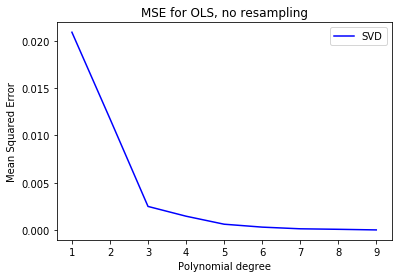

In [28]:
ols_mse = []
ols_svds = []

poly_degrees = np.arange(1,10)
for i in poly_degrees:
    X = Model(x,y,i)
    ols_mse.append(NoResampling(X,z_n,0.,'ols')[0])
    ols_svds.append(NoResampling(X,z_n,0.,'svd')[0])
plt.figure()
# plt.plot(poly_degrees,ols_mse,'r',label='OLS')
plt.plot(poly_degrees,ols_svds,'b',label='SVD')
plt.xlabel("Polynomial degree")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.title("MSE for OLS, no resampling")
plt.show()

### Evaluating R2

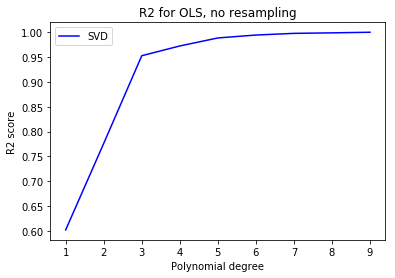

In [29]:
ols_r2 = []
svd_r2 = []
for i in poly_degrees:
    X = Model(x,y,i)
    ols_r2.append(NoResampling(X,z_n,0.,'ols')[1])
    svd_r2.append(NoResampling(X,z_n,0.,'svd')[1])
plt.figure()
# plt.plot(poly_degrees,ols_r2,'r',label='OLS')
plt.plot(poly_degrees,svd_r2,'b',label='SVD')

plt.xlabel("Polynomial degree")
plt.ylabel("R2 score")
plt.legend()
plt.title("R2 for OLS, no resampling")
plt.show()

# b

### Beta values and CI with resampling

In [30]:
poly_degrees=np.arange(1,6)

print("kFold resampling with k = ", k)
# for i in poly_degrees:
    X = Model(x,y,i)
    print("---------------")
    print("\\begin{table}[]")
    print("\\centering")
    print("\\caption{{OLS method, polynomial degree {}}}".format(i))
    print("\\begin{tabular}{|c|cc|l|}")
    print("\\hline")
    print("\\multicolumn{1}{|l|}{\\multirow{2}{*}{Coefficient}} & \\multicolumn{2}{l|}{Confidence interval = $\\beta_{mean}$ $\\pm$ 2*$\\sigma_{mean}$} & \\multirow{2}{*}{$\\beta_{variance}$} \\\\")
    print("\\multicolumn{1}{|l|}{}  & $\\beta_{mean}$                        & $\\sigma_{mean}$                       &                                     \\\\ \hline")   
    b_OLS =np.mean(kFold(X,z_n,k,0.)[4],axis=0)
    z_OLS =np.mean(kFold(X,z_n,k,0.)[3],axis=0)
    LatexPrinter(b_OLS,z_OLS)
    print("\\end{tabular}")
    print("\\label{{tab:no.{}}}".format(i))
    print("\\end{table}")

IndentationError: unexpected indent (<ipython-input-30-5fc66a19ea6f>, line 5)

### Evaluating MSE

0.002141176515856933
0.9592806636243864
0.000584705263513425
0.9888576175759267


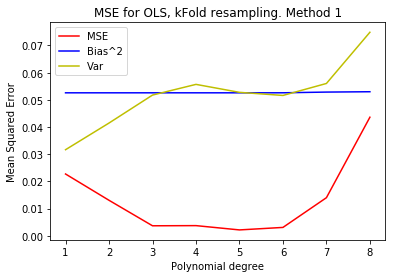

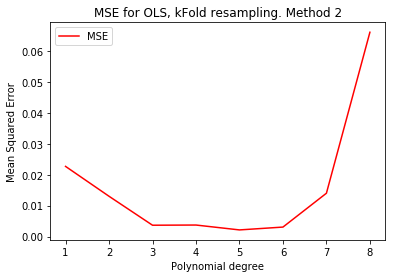

In [33]:
ols_k_mse = []
ols_k_bias = []
ols_k_var = []
ols_k_r2 = []
ols_k_r2_tr = []
ols_k_mse_tr = []
_lambda = 0.
poly_degrees = np.arange(1,9)
for i in poly_degrees:
    X = Model(x,y,i)
    X_s = X
    z_n_s = z_n
    X_s,z_n_s = Shuffler(X_s,z_n_s)
    
    mii,bii,vii,til,tes,bet,rr2,msetr, r2tr = kFolds(X_s,z_n_s,10)
#     ols_k_mse.append(MSE(til,tes))
    ols_k_mse.append(mii)
    ols_k_mse_tr.append(msetr)
    ols_k_r2_tr.append(r2tr)
    ols_k_var.append(np.var(til))
    ols_k_bias.append(Bias(tes,til))
    ols_k_r2.append(R2(tes,til))
print(ols_k_mse[4])
print(ols_k_r2[4])
print(ols_k_mse_tr[4])
print(ols_k_r2_tr[4])

plt.figure()
plt.plot(poly_degrees,ols_k_mse,'r',label='MSE')
plt.plot(poly_degrees,ols_k_bias,'b',label='Bias^2')
plt.plot(poly_degrees,ols_k_var,'y',label='Var')
plt.xlabel("Polynomial degree")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.title("MSE for OLS, kFold resampling. Method 1")
plt.show()


jols_k_mse = []
jols_k_bias = []
jols_k_var = []
for i in poly_degrees:
    X = Model(x,y,i)
    X_s = X
    z_n_s = z_n
    X_s,z_n_s = Shuffler(X_s,z_n_s)

    mii,bii,vii,til,tes,bet = kFold(X_s,z_n_s,10,0.)
    jols_k_mse.append(np.mean(mii))
    jols_k_var.append(np.mean(vii))
    jols_k_bias.append(np.mean(bii))
    
plt.figure()
plt.plot(poly_degrees,jols_k_mse,'r',label='MSE')
# plt.plot(poly_degrees,jols_k_bias,'b',label='Bias^2')
# plt.plot(poly_degrees,jols_k_var,'y',label='Var')
plt.xlabel("Polynomial degree")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.title("MSE for OLS, kFold resampling. Method 2")
plt.show()



# ols_k_mse = []
# ols_k_bias = []
# ols_k_var = []
# for i in poly_degrees:
#     X = Model(x,y,i)
#     X_s = X
#     z_n_s = z_n
#     X_s,z_n_s = Shuffler(X_s,z_n_s)
    
#     mii,bii,vii,til,tes,bet,kkk,lll,ooo = kFolds(X_s,z_n_s,10)
#     z_tilders = X_s@bet
#     ols_k_mse.append(MSE(z_tilders,z_n_s))
#     ols_k_var.append(np.var(z_tilders))
#     ols_k_bias.append(Bias(z_n_s,z_tilders))

# plt.figure()
# plt.plot(poly_degrees,ols_k_mse,'r')
# plt.plot(poly_degrees,ols_k_bias,'b')
# plt.plot(poly_degrees,ols_k_var,'y')
# plt.xlabel("Polynomial degree")
# plt.ylabel("Mean Squared Error")
# plt.title("MSE for OLS, kFold resampling")
# plt.show()

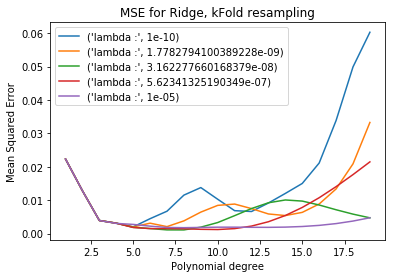

mse_test: 0.0011889,R2_test: 0.9778371,MSE_tr: 0.0002058,R2_tr: 0.9960936 for lambda: 5.62341325190349e-07 


In [67]:
# RIDGE!!!!!!!!!
# ols_k_mse = []
# ols_k_bias = []
# ols_k_var = []
# ols_k_r2 = []
# ols_k_r2_tr = []
# ols_k_mse_tr = []
_lambda = np.logspace(-10,-5,5)
poly_degrees=np.arange(1,20)
ols_k_mse_r = np.zeros((len(_lambda),len(poly_degrees)))
ols_k_bias_r = np.zeros((len(_lambda),len(poly_degrees)))
ols_k_var_r = np.zeros((len(_lambda),len(poly_degrees)))
ols_k_r2_r = np.zeros((len(_lambda),len(poly_degrees)))
ols_k_r2_r_tr = np.zeros((len(_lambda),len(poly_degrees)))
ols_k_mse_r_tr = np.zeros((len(_lambda),len(poly_degrees)))

# poly_degrees = np.arange(1,9)
c=0
for i in poly_degrees:
    X = Model(x,y,i)
    X_s = X
    z_n_s = z_n
    X_s,z_n_s = Shuffler(X_s,z_n_s)

    for j,l in enumerate(_lambda):
        mii,bii,vii,til,tes,bet,r2s,mstr,r2tr = kFoldsRidge(X_s,z_n_s,k,l)
#         print(i,l,mii)
        ols_k_mse_r[j,i-1] = mii
        ols_k_bias_r[j,i-1] = bii
        ols_k_var_r[j,i-1] = vii
        ols_k_r2_r[j,i-1] = r2s
        ols_k_mse_r_tr[j,i-1] = mstr
        ols_k_r2_r_tr[j,i-1] = r2tr

#         ols_k_mse.append(np.mean(mii))
#         ols_k_var.append(np.mean(bii))
#         ols_k_bias.append(np.mean(vii))
# print(pls_k_mse_r)
plt.figure()
for i in range(len(_lambda)):
    plt.plot(poly_degrees,ols_k_mse_r[i,:],label=('lambda :',_lambda[i]))
#     plt.plot(poly_degrees,ols_k_bias_r[i,:],'b',label='Bias^2')
#     plt.plot(poly_degrees,ols_k_var_r[i,:],'y',label='Var')
plt.xlabel("Polynomial degree")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.title("MSE for Ridge, kFold resampling")
plt.show()
print("mse_test: {},R2_test: {},MSE_tr: {},R2_tr: {} for lambda: {} ".format(round(ols_k_mse_r[3][9],7),round(ols_k_r2_r[3][9],7),round(ols_k_mse_r_tr[3][9],7),round(ols_k_r2_r_tr[3][9],7),_lambda[3]))

1
2
3
4
5
6
7
8
9
10
11


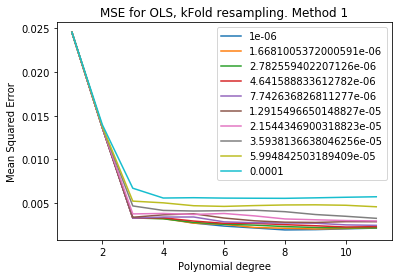

In [106]:
#LASSO!!!!!!
_lambda = np.logspace(-6,-4,10)
poly_degrees=np.arange(1,12)
ols_k_mse_r = np.zeros((len(_lambda),len(poly_degrees)))
ols_k_bias_r = np.zeros((len(_lambda),len(poly_degrees)))
ols_k_var_r = np.zeros((len(_lambda),len(poly_degrees)))
ols_k_r2_r = np.zeros((len(_lambda),len(poly_degrees)))
ols_k_r2_r_tr = np.zeros((len(_lambda),len(poly_degrees)))
ols_k_mse_r_tr = np.zeros((len(_lambda),len(poly_degrees)))

# poly_degrees = np.arange(1,9)
c=0
for i in poly_degrees:
    X = Model(x,y,i)
    X_s = X
    z_n_s = z_n
    X_s,z_n_s = Shuffler(X_s,z_n_s)
    print(i)
    for j,l in enumerate(_lambda):

#     for j,l in enumerate(_lambda):
#     mii,r2,bet = kFoldLassoCV(X_s,z_n_s,k,_lambda)
#         muppet = kFoldLasso(X_s,z_n_s,k,l)
        mii,r2s,bet,miitr,r2tr = kFoldLasso(X_s,z_n_s,k,l)
        ols_k_mse_r[j,i-1] = mii
#         ols_k_bias_r[j,i-1] = bii
#         ols_k_var_r[j,i-1] = vii
        ols_k_r2_r[j,i-1] = r2s
        ols_k_mse_r_tr[j,i-1] = miitr
        ols_k_r2_r_tr[j,i-1] = r2tr
# #         print(i,l,mii)
#     ols_k_mse_r[j,i-1] = mii
#         ols_k_mse.append(np.mean(mii))
#         ols_k_var.append(np.mean(bii))
#         ols_k_bias.append(np.mean(vii))
# print(pls_k_mse_r)
plt.figure()
for i in range(len(_lambda)):
    plt.plot(poly_degrees,ols_k_mse_r[i,:],label=_lambda[i])
# plt.plot(poly_degrees,ols_k_bias,'b',label='Bias^2')
# plt.plot(poly_degrees,ols_k_var,'y',label='Var')
plt.xlabel("Polynomial degree")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.title("MSE for OLS, kFold resampling. Method 1")
plt.show()

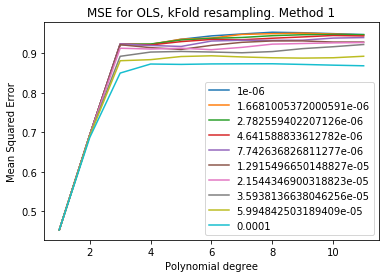

mse_tr 0.0006745 r2_tr 0.9869749 mse_te 0.002109 r2te 0.9501375


In [146]:
plt.figure()
for i in range(len(_lambda)):
    plt.plot(poly_degrees,ols_k_r2_r[i,:],label=_lambda[i])
# plt.plot(poly_degrees,ols_k_bias,'b',label='Bias^2')
# plt.plot(poly_degrees,ols_k_var,'y',label='Var')
plt.xlabel("Polynomial degree")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.title("MSE for OLS, kFold resampling. Method 1")
plt.show()
# lam først
print("mse_tr {} r2_tr {} mse_te {} r2te {}".format(round(ols_k_mse_r_tr[0,9],7),round(ols_k_r2_r_tr[0,9],7),round(ols_k_mse_r[0,9],7),round(ols_k_r2_r[0,9],7)))

In [118]:
_lams= np.logspace(-5,-2)
ols_k_mse_lasso = np.zeros((len(_lams),len(poly_degrees)))

for i in poly_degrees:
    print(i)
    X = Model(x,y,i)
    X_s = X
    z_n_s = z_n
    X_s,z_n_s = Shuffler(X_s,z_n_s)
#     msess=[]

    for j,l in enumerate(_lambda):

        msee,bib, bob= kFoldLassoCV(X_s,z_n_s,k,[l])
#         msess.append(msee)
        ols_k_mse_lasso[j,i-1] = msee

    
# plt.plot(msess)

1
2
3
4
5
6
7
8
9
10
11


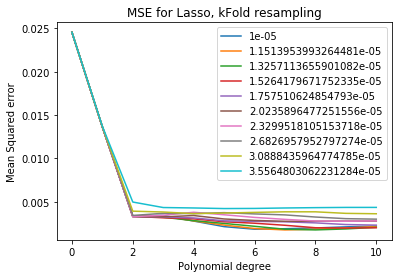

(10, 11)
11


In [141]:
plt.figure()
for i in range(len(poly_degrees)-1):
    plt.plot(ols_k_mse_r[:][i],label=_lams[i])
plt.legend()
plt.xlabel('Polynomial degree')
plt.ylabel('Mean Squared error')
plt.title('MSE for Lasso, kFold resampling')
plt.show()
print(np.shape(ols_k_mse_r))
print(len(poly_degrees))

# plt.figure()
# plt.plot()

In [ ]:
ols_k_mse = []
ols_k_bias = []
ols_k_var = []
_lambda = 0.
poly_degrees = np.arange(1,9)
for i in poly_degrees:
    X = Model(x,y,i)
    X_s,z_n_s = Shuffler(X,z_n)
    aii,bii,zii,ddd = kFoldskl(X_s,z_n_s,5,0.)
#     aii,bii,zii,kii,lii = kFolds(X,z_n,5)
#     ols_k_mse.append(np.mean(aaa))
    ols_k_mse.append(np.mean(aii))
    ols_k_var.append(np.mean(bii))
    ols_k_bias.append(np.mean(zii))

plt.figure()
plt.plot(poly_degrees,ols_k_mse,'r')
# plt.plot(poly_degrees,ols_k_bias,'b')
# plt.plot(poly_degrees,ols_k_var,'y')
ip = []
# for i in range(len(ols_k_var)):
#     ip.append((ols_k_var[i]+ols_k_bias[i]))
# plt.plot(poly_degrees,ip,'k')


plt.xlabel("Polynomial degree")
plt.ylabel("Mean Squared Error")
plt.title("MSE for OLS, kFold resampling")
plt.show()

### Evaluating R2

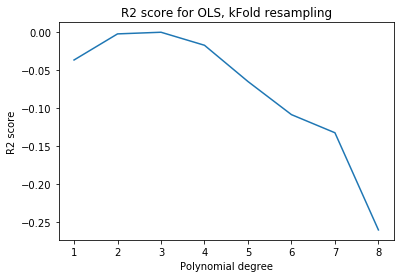

In [29]:
ols_k_r2 = []

for i in poly_degrees:
    X = Model(x,y,i)
#     aii,bii,zii,ddd = kFoldskl(X,z_n,5,0.)
    aii,bii,zii,kii,lii,ddd = kFold(X,z_n,5,0.)

#     print(np.shape(fii))
    ols_k_r2.append(np.mean(ddd))


plt.figure()
plt.plot(poly_degrees,ols_k_r2)

plt.xlabel("Polynomial degree")
plt.ylabel("R2 score")
plt.title("R2 score for OLS, kFold resampling")
plt.show()

# c

#### Bias variance needs helpz

# d

In [ ]:
# poly_degrees=np.arange(1,6)
# lambda_range = np.logspace(-5,0,20)
# beta_path = np.zeros((len(poly_degrees),len(lambda_range),21))
# for i in poly_degrees:
#     X = Model(x,y,i)
#     for j,lam in enumerate(lambda_range):
#         mid = kFoldRidge(k,X,z_n,lam)[2]


### kinda random stuff below

In [ ]:
maxpd = 8
_lam = 0.0001
No_resampling = []
kfold_resampling = []
kfold_resampling_skl = []
kfold_ridge = []
kfold_lasso = []

for i in range(maxpd):
    X = Model(x,y,i+1)
    No_resampling.append(NoResampling(X,z_n,_lam)[0])
    kfold_resampling.append(kFold(k,X,z_n)[0])
    kfold_resampling_skl.append(kFoldskl(k,X,z_n)[0])
    kfold_ridge.append(kFoldRidge(k,X,z_n,_lam)[0])
#     kfold_lasso.append(kFoldLassoCV(k,X,z_n,0.000001)[0])
plt.figure()
plt.plot(No_resampling,'b')
plt.plot(kfold_resampling,'r')
plt.plot(kfold_resampling_skl,'y')
plt.plot(kfold_ridge,'k')
# plt.plot(kfold_lasso,'c')
plt.figure()
plt.show()

In [ ]:
pd = 5

_lams = np.logspace(-4,0,20)
# _lams = np.linspace(1e-4,1.,20)

X = Model(x,y,pd)
fish=[]
rish=[]

for i in _lams:
    fish.append(kFoldRidge(k,X,z_n,i)[0])
    rish.append(kFoldRidge(k,X,z_n,i)[1])
plt.figure()
plt.plot(_lams,fish)
plt.title("mse ridge")
plt.xlabel("lambdas")
plt.show()
plt.figure()
plt.plot(_lams,rish)
plt.title("r2 ridge")
plt.xlabel("lambdas")

plt.show()

In [ ]:
X_c = np.delete(X-np.mean(X,axis=0),0,1)
z_n_c = z_n -np.mean(z_n)

X = Model(x,y,pd)
fish=[]
rish=[]

for i in _lams:
    fish.append(kFoldLassoCV(k,X,z_n,i)[0])
    rish.append(kFoldLassoCV(k,X,z_n,i)[1])
plt.figure()
plt.plot(_lams,fish)
plt.title("mse kfold lasso")
plt.xlabel("lambdas")

plt.show()
plt.figure()
plt.plot(_lams,rish)
plt.title("r2 kfold lasso")
plt.xlabel("lambdas")

plt.show()

# b

In [ ]:
NN = 5
mpd = 9
k=10
ms = []
rs = []
vs = []
bs = []

for i in range(mpd):
    X = Model(x,y,i+1)
    Xn,z_nn=Shuffler(X,z_n)
    msi=0
    rsi = 0
    vsi = 0
    bsi = 0
    
#     for l in range(NN):
    msi = kFold(k,Xn,z_nn)[0]
    rsi = kFold(k,Xn,z_nn)[1]
    vsi = kFold(k,Xn,z_nn)[3]
    bsi = kFold(k,Xn,z_nn)[4]
    ms.append(msi)
    rs.append(rsi)
    vs.append(vsi)
    bs.append(bsi)
    
plt.figure()
plt.plot(np.arange(mpd)+1,ms)
plt.title("mse kFold for polydegree, 5 reruns")
plt.show()

plt.figure()
plt.plot(vs)
plt.title("Var kFold for polydegree, 5 reruns")
plt.show()
ulp = []
for i in range(len(bs)):
    ulp.append(bs[i])
plt.figure()
plt.plot(bs)
# plt.plot(ms,'k')
plt.title("Bias2 kFold for polydegree, 5 reruns")
plt.show()


# plt.figure()
# plt.plot(np.arange(mpd)+1,rs)
# plt.title("r2 kFold for polydegree, 5 reruns")
# plt.show()

# print(np.shape(bs),np.shape(vs))
# plt.figure()
# # plt.plot(np.arange(mpd)+1,ms)
# # plt.plot(np.arange(mpd)+1,ms)
# bst = [i /90 for i in bs]
# plt.plot(bst)
# plt.plot(vs)
# plt.show()

In [ ]:
#Run NN kFolds to create bias/variance plot
#My bias increases again with model complexity
NN=5
mpd = 15
qq = len(z_n)

#sort noisy signal
z_n_sorted = sorted(z_n)

#initialize variables 
NMSE_k = np.zeros(shape=(NN,mpd)) #MSE stored for each run of kFold
model_values = np.zeros(shape=(NN,mpd,qq))
bias2 = np.zeros(mpd)
var = np.zeros(mpd)
bias2_ = np.zeros(shape=(mpd,qq))
var_ = np.zeros(shape=(mpd,qq))

# betas = np.zeros(shape=(NN,mpd))
betas=[]
#Run NN kFolds
for l in range(NN):
    #shuffle here
    for i in range(mpd):
        X = Model(x,y,i+1)
#         model_values[l,i] = kFoldskl(k,X,z_n)[0]
        model_values[l,i] = kFold(k,X,z_n)[0]
        NMSE_k[l,i] = MSE(model_values[l,i],z_n_sorted)
        if l == 0:
            betas.append(kFold(k,X,z_n)[1])
NMSE = np.mean(NMSE_k,axis=0)

#Calculate bias and variance for each polynomial degree
for i in range(mpd):
    for m in range(qq):
        bias2_[i,m] = np.mean(model_values[:,i,m])
        var_[i,m] = np.var(model_values[:,i,m])
    bias2[i]=np.mean((z_n_sorted-bias2_[i])**2)
    var[i] = np.mean(var_[i])

In [ ]:
ols_noise = 8
legs = 'MSE','Bias','var','Bias+Var'
plt.figure()
maxi = 8
plt.plot(np.arange(1,maxi+1),NMSE[:maxi],'k')
plt.plot(np.arange(1,maxi+1),bias2[:maxi],'g')
plt.plot(np.arange(1,maxi+1),var[:maxi],'b')
plt.plot(np.arange(1,maxi+1),bias2[:maxi]+var[:maxi],'ro')
plt.xlabel('Ploynomial degree')
plt.ylabel('MSE')
plt.title('MSE and bias as functions of polynomial degree, CV')
plt.legend(legs)
plt.show()

In [ ]:
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
xp = np.arange(0,1,0.05)
yp = np.arange(0,1,0.05)
xp,yp = np.meshgrid(xp,yp,sparse=False)
xz,yz = np.meshgrid(xp,yp,sparse=True)
pd = 9
fz = FrankeFunction(xp,yp)
for i in range(pd):
    axs = fig.add_subplot(3,3,i+1,projection='3d')
    Xp = Model(xz,yz,i+1)
    zp = Xp@betas[i]
    zp.shape=(20,20)
    axs.plot_surface(xp,yp,zp,cmap=cm.coolwarm,linewidth=0,antialiased=False)
#     axs.plot_surface(xp,yp,fz,cmap=cm.coolwarm,linewidth=0,antialiased=False)
    axs.set_xlabel('x')
    axs.set_ylabel('y')
    axs.set_zlabel('z')
    axs.set_title('Polynomial degree = {}'.format(i+1))
    axs.set_zlim(-0.10,1.40)
    axs.zaxis.set_major_locator(LinearLocator(10))
    axs.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    fig.colorbar(surf,shrink=0.5, aspect=5,pad = 0.1)

plt.show()

In [ ]:
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
xp = np.arange(0,1,0.05)
yp = np.arange(0,1,0.05)
xp,yp = np.meshgrid(xp,yp,sparse=False)
xz,yz = np.meshgrid(xp,yp,sparse=True)
pd = 9
fz = FrankeFunction(xp,yp)
for i in range(pd):
    axs = fig.add_subplot(3,3,i+1)
    Xp = Model(xz,yz,i+1)
    zp = Xp@betas[i]
    zp.shape=(20,20)
#     plo = zp-fz
    plo = np.subtract(zp,fz)
#     print("a",zp[0],"b",fz[0],"c",plo[0])
    aa = axs.contourf(plo,cmap=cm.coolwarm)
#     axs.plot(plo[0],plo[1])
#     axs.plot_surface(xp,yp,zp,cmap=cm.coolwarm,linewidth=0,antialiased=False)
    axs.set_xlabel('x')
    axs.set_ylabel('y')
#     axs.addaxes(xp)
#     axs.set_zlabel('z')
#     axs.set_title('Polynomial degree = {}'.format(i+1))
#     axs.set_zlim(-0.10,1.40)
#     axs.zaxis.set_major_locator(LinearLocator(10))
#     axs.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    fig.colorbar(aa,shrink=0.5, aspect=5,pad = 0.1)

plt.show()

In [ ]:
ols_noise = 8
legs = 'MSE','Bias','var','Bias+Var'
plt.figure()
maxi = 9
plt.plot(np.arange(1,maxi+1),NMSE[:maxi],'k')
plt.plot(np.arange(1,maxi+1),bias2[:maxi],'g')
plt.plot(np.arange(1,maxi+1),var[:maxi],'b')
plt.plot(np.arange(1,maxi+1),bias2[:maxi]+var[:maxi],'ro')
plt.xlabel('Ploynomial degree')
plt.ylabel('MSE')
plt.title('MSE and bias as functions of polynomial degree, CV')
plt.legend(legs)
plt.show()

In [ ]:
maxpd = 5
for i in range(maxpd):
    print("Polynomial degree", i+1)
    X = Model(x,y,i+1)
#     X = X-np.mean(X,axis=0)
#     X[:,0]=1.
#     z_n = z_n -np.mean(z_n)
    ztilde = kFold(k,X,z_n)[0]
    print("OLS")
    print("beta",kFold(k,X,z_n)[1])
    print("pm",1.96*np.sqrt(abs(VarOLS(z_n, ztilde, i,X))))
    print("variance",VarOLS(z_n,ztilde,i,X))
    ztilde = kFoldRidge(k,X,z_n,100.1)[0] #just a random lambda value
    print("Ridge")
    print("beta",kFoldRidge(k,X,z_n,0.1)[1])
    print("pm",1.96*np.sqrt(abs(VarOLS(z_n, ztilde, i,X))))
#     print("variance",VarOLS(z_n,ztilde,i,X))
    print("variance",VarRidge(X,10000.1))
    ztilde = kFoldLassoCV(k,X,z_n,[100.001,100.01])
    print("Lasso")
    print("beta",kFold(k,X,z_n)[1])
    print("pm",1.96*np.sqrt(abs(VarOLS(z_n, ztilde, i,X))))
    print("variance",VarOLS(z_n,ztilde,i,X))
    print("-------------------")
    ### ALL VARIANCES ARE THE SAME, WHY?!?!

# c

In [ ]:
_lams = np.logspace(-4,0,10)
kFoldLassoCV(k,X,z_n,_lams)

In [ ]:
MPD = np.arange(9)+1#np.arange(9)+1
MSE_degree = []


#shuffle data before doing the kFold
# n = len(X[0,:])
# combi = np.c_[X,z_n]
# np.random.shuffle(combi)
# X, z_n = combi[:,:n], combi[:,n]
# X_new,z_n_new = Shuffler(X,z_n)
for i in MPD:
    X = Model(x,y,i)
    
    z_out = kFold(k,X,z_n)
#     dMSE, dR2 = NoResampling(X,z_n,0)
#     dMSE,dR2 = kFoldskl(k,X,z_n)
#     print(i,dMSE)
    MSE_degree.append(MSE(z_out,z_n_sorted))
# MS = MSE(MSE_degree,z_n)

In [ ]:
plt.figure()
plt.plot(MPD+1,MSE_degree)
plt.xlabel('Polynomial degree')
plt.ylabel('Mean squared error')
plt.show()

# d

In [ ]:
_lambda = np.logspace(-4,5,10)

RidgeMSE = np.zeros((len(MPD),len(_lambda)))
RidgeR2 = np.zeros((len(MPD),len(_lambda)))



for i,mpd in enumerate(MPD):
    X = Model(x,y,mpd)
    for j,lam in enumerate(_lambda):
#         rMSE,rR2 = NoResampling(X,z_n,lam)
        z_out = kFoldRidge(k,X,z_n,lam)
        RidgeMSE[i][j] = MSE(z_out,z_n_sorted)
        RidgeR2[i][j] = R2(z_n_sorted,z_out)

In [ ]:
plt.figure()

for i in range(len(_lambda)):
    plt.semilogy(MPD,RidgeMSE[:,i],label=_lambda[i])
plt.xlabel('Polynomial degree')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [ ]:
plt.figure()

for i in range(len(MPD)):
    plt.loglog(_lambda,RidgeMSE[i,:],label=i+1)
plt.xlabel('lambda')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# e

In [ ]:
# I'll use Scikit-learn as recommended for this
_lambda = np.logspace(-4,5,100)
beta_store = []
X = Model(x,y,5)
k=5
kFoldLassoCV(k,X,z_n,_lambda)
# for i in range(10):
#     np.random.seed(i)
#     uno,dos,tres = kFoldLassoCV(k,X,z_n,_lambda)
#     print(tres)
#     beta_store.append(tres)
# print(np.shape(tres))

In [ ]:
terrain = imread('SRTM_data_Norway_1.tif')
terr_square = terrain[0:100,0:100]
print(np.shape(terr_square))

In [ ]:
terra = np.matrix.flatten(terr_square)
print(np.shape(terra))
# x = np.linspace(0,len(terr_square[0]),100)
# y = np.linspace(0,len(terr_square[1]),100)
x = np.linspace(0,1,np.sqrt(len(terra)))
y=np.linspace(0,1,np.sqrt(len(terra)))
x, y = np.meshgrid(x,y,sparse=False)


In [ ]:
X = Model(x,y,5)


X_c = X-np.mean(X,axis=0)
X_c[:,0]=1.
terra_c = terra -np.mean(terra)

In [ ]:
NoResampling(X,terra,0.)

In [ ]:
betas=[]
mpd = 6
for i in range(mpd):
        X = Model(xp,yp,i+1)
        print(np.shape(X))
#         model_values[l,i] = kFoldskl(k,X,z_n)[0]
#         model_values[l,i] = kFold(k,X,z_n)[0]
#         NMSE_k[l,i] = MSE(model_values[l,i],z_n_sorted)
#         if l == 0:
        betas.append(kFold(k,X,terra)[1])

In [ ]:
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
# xp = np.arange(0,1,0.05)
# yp = np.arange(0,1,0.05)


xp = np.linspace(0,1,len(terr_square[0]))
yp=np.linspace(0,1,len(terr_square[1]))

xp,yp = np.meshgrid(xp,yp,sparse=False)
xz,yz = np.meshgrid(xp,yp,sparse=True)
pd = 9
# fz = FrankeFunction(xp,yp)


betas=[]
for i in range(pd):
        X = Model(xp,yp,i+1)
        betas.append(kFold(k,X,terra)[1])

for i in range(pd):
    axs = fig.add_subplot(3,3,i+1,projection='3d')
    Xp = Model(xp,yp,i+1)
    zp = Xp@betas[i]
    zp.shape=(len(xp),len(yp))
    axs.plot_surface(xp,yp,zp,cmap=cm.coolwarm,linewidth=0,antialiased=False)
#     axs.plot_surface(xp,yp,terr_square,cmap=cm.coolwarm,linewidth=0,antialiased=False)
    axs.set_xlabel('x')
    axs.set_ylabel('y')
    axs.set_zlabel('z')
    axs.set_title('Polynomial degree = {}'.format(i+1))
#     axs.set_zlim(-0.10,1.40)
    axs.zaxis.set_major_locator(LinearLocator(10))
    axs.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    fig.colorbar(surf,shrink=0.5, aspect=5,pad = 0.1)

plt.show()

In [ ]:
fig2 = plt.figure()
axers = fig2.gca(projection='3d')

for i in range(pd):
    surf = axers.plot_surface(xp,yp,terr_square,cmap=cm.coolwarm,linewidth=0,antialiased=False)
plt.show()

In [ ]:
pd = 5
_lams = np.linspace(0.0,1.,10)
X = Model(x,y,pd)
fish=[]
for i in range(len(_lams)):
    fish.append(kFoldRidge(k,X,z_n,i))

In [ ]:
import pandas as pd

data = pd.read_csv("Oppgave_a.csv")
# row2 = data.iloc[3]
# print(row2)

In [ ]:
def LatexPrinter(betas,variances):
    for i in range(len(betas)-1):#%.2f
        print("$\\beta_{{{}}}$ & {} & {} \\\ ".format(i,round(betas[i],7),round(variances[i],7)))
    print("$\\beta_{{{}}}$ & {} & {} \\\ \\hline".format(i,round(betas[i],7),round(variances[i],7)))

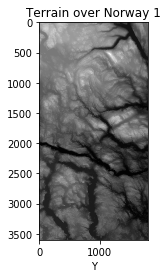

In [200]:















terrain = imread('SRTM_data_Norway_1.tif')
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain, cmap='gray')
plt.xlabel('X')
plt.xlabel('Y')
plt.show()

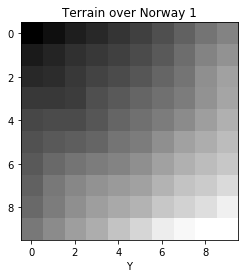

In [204]:
terrain = imread('SRTM_data_Norway_1.tif')
terr_square = terrain[0:10,0:10]
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terr_square, cmap='gray')
plt.xlabel('X')
plt.xlabel('Y')
plt.show()
terr_flat = np.matrix.flatten(terr_square)

In [205]:
x = np.linspace(0,1,10)
y = np.linspace(0,1,10)
x,y = np.meshgrid(x,y)

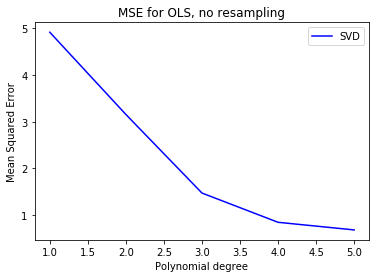

In [206]:
ols_svds = []

poly_degrees = np.arange(1,6)
for i in poly_degrees:
    X = Model(x,y,i)
# #     ols_mse.append(NoResampling(X,z_n,0.,'ols')[0])
    ols_svds.append(NoResampling(X,terr_flat,0.,'svd')[0])
plt.figure()
# # plt.plot(poly_degrees,ols_mse,'r',label='OLS')
plt.plot(poly_degrees,ols_svds,'b',label='SVD')
plt.xlabel("Polynomial degree")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.title("MSE for OLS, no resampling")
plt.show()

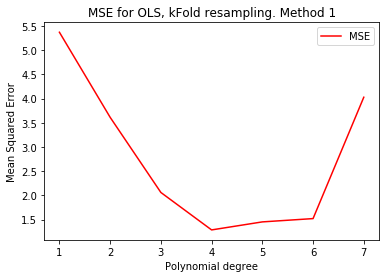

In [207]:
ols_k_mse = []
ols_k_bias = []
ols_k_var = []
ols_k_r2 = []
ols_k_r2_tr = []
ols_k_mse_tr = []
_lambda = 0.
poly_degrees = np.arange(1,8)
for i in poly_degrees:
    X = Model(x,y,i)
    X_s = X
    z_n_s = terr_flat
    X_s,z_n_s = Shuffler(X_s,z_n_s)
    
    mii,bii,vii,til,tes,bet,rr2,msetr, r2tr = kFolds(X_s,z_n_s,10)
#     ols_k_mse.append(MSE(til,tes))
    ols_k_mse.append(mii)
    ols_k_mse_tr.append(msetr)
#     ols_k_r2_tr.append(r2tr)
#     ols_k_var.append(np.var(til))
#     ols_k_bias.append(Bias(tes,til))
#     ols_k_r2.append(R2(tes,til))
# print(ols_k_mse[4])
# print(ols_k_r2[4])
# print(ols_k_mse_tr[4])
# print(ols_k_r2_tr[4])

plt.figure()
plt.plot(poly_degrees,ols_k_mse,'r',label='MSE')
# plt.plot(poly_degrees,ols_k_bias,'b',label='Bias^2')
# plt.plot(poly_degrees,ols_k_var,'y',label='Var')
plt.xlabel("Polynomial degree")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.title("MSE for OLS, kFold resampling. Method 1")
plt.show()


# jols_k_mse = []
# jols_k_bias = []
# jols_k_var = []
# for i in poly_degrees:
#     X = Model(x,y,i)
#     X_s = X
#     z_n_s = z_n
#     X_s,z_n_s = Shuffler(X_s,z_n_s)

#     mii,bii,vii,til,tes,bet = kFold(X_s,z_n_s,10,0.)
#     jols_k_mse.append(np.mean(mii))
#     jols_k_var.append(np.mean(vii))
#     jols_k_bias.append(np.mean(bii))
    
# plt.figure()
# plt.plot(poly_degrees,jols_k_mse,'r',label='MSE')
# # plt.plot(poly_degrees,jols_k_bias,'b',label='Bias^2')
# # plt.plot(poly_degrees,jols_k_var,'y',label='Var')
# plt.xlabel("Polynomial degree")
# plt.ylabel("Mean Squared Error")
# plt.legend()
# plt.title("MSE for OLS, kFold resampling. Method 2")
# plt.show()
